In [1]:
#REQUIRED LIBRARIES
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.layers import CuDNNGRU,GRU
from sklearn.preprocessing import StandardScaler
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from numpy import newaxis
from collections import Counter
from imblearn.under_sampling import TomekLinks
import os
import random
import lightgbm as gbm
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score

/home/alper/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/alper/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/alper/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will b

In [2]:
#REPRODUCABLE RESULT
seed_value= 2020
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)

In [3]:
#DATASET LOADING
training = pd.read_csv("UNSW_NB15_total_numeric_training.csv")
testing = pd.read_csv("UNSW_NB15_total_numeric_testing.csv")

x_tr = training.drop(["id","label","attack_cat"],axis=1)
y_tr = training[["attack_cat"]]
                      
x_ts = testing.drop(["id","label","attack_cat"],axis=1)
y_ts = testing[["attack_cat"]]

In [4]:
#DATASET DIVIDING FOR TESTING
x_tr_p1,x_tr_p2,y_tr_p1,y_tr_p2 = train_test_split(x_tr,y_tr,test_size=0.5,stratify=y_tr,random_state=34)

In [5]:
#LIGHTGBM FEATURE SELECTION PROCESS
start = time()
lgb_train = gbm.Dataset(x_tr_p1,y_tr_p1,
                        feature_name=['dur','proto','service','state','spkts','dpkts','sbytes','dbytes',
                                      'rate','sttl','dttl','sload','dload','sloss','dloss','sinpkt','dinpkt',
                                      'sjit','djit','swin','stcpb','dtcpb','dwin','tcprtt','synack','ackdat',
                                      'smean','dmean','trans_depth','response_body_len','ct_srv_src',
                                      'ct_state_ttl','ct_dst_ltm','ct_src_dport_ltm','ct_dst_sport_ltm',
                                      'ct_dst_src_ltm','is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd',
                                      'ct_src_ltm','ct_srv_dst','is_sm_ips_ports'],
                        categorical_feature=['service','state','sttl','dttl','is_ftp_login','ct_ftp_cmd'])

lgb_eval = gbm.Dataset(x_tr_p1,y_tr_p1,reference=lgb_train)
params = {
    'task': 'train',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class':10,
    'learning_rate': 0.03,
    'verbose': 0,
    'tree_learner': 'voting',
}
evals={}
clf = gbm.train(params,lgb_train,num_boost_round=50,valid_sets=lgb_eval,evals_result=evals,early_stopping_rounds=3)
print("Training %.2f seconds:" % ((time() - start)))

/home/alper/.local/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/alper/.local/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ct_ftp_cmd', 'dttl', 'is_ftp_login', 'service', 'state', 'sttl']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/alper/.local/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's multi_logloss: 1.67252
Training until validation scores don't improve for 3 rounds.
[2]	valid_0's multi_logloss: 1.6185
[3]	valid_0's multi_logloss: 1.56725
[4]	valid_0's multi_logloss: 1.52049
[5]	valid_0's multi_logloss: 1.47705
[6]	valid_0's multi_logloss: 1.43662
[7]	valid_0's multi_logloss: 1.39854
[8]	valid_0's multi_logloss: 1.36295
[9]	valid_0's multi_logloss: 1.32901
[10]	valid_0's multi_logloss: 1.29695
[11]	valid_0's multi_logloss: 1.2665
[12]	valid_0's multi_logloss: 1.23738
[13]	valid_0's multi_logloss: 1.20968
[14]	valid_0's multi_logloss: 1.18327
[15]	valid_0's multi_logloss: 1.15807
[16]	valid_0's multi_logloss: 1.13397
[17]	valid_0's multi_logloss: 1.11091
[18]	valid_0's multi_logloss: 1.08884
[19]	valid_0's multi_logloss: 1.06763
[20]	valid_0's multi_logloss: 1.04736
[21]	valid_0's multi_logloss: 1.02769
[22]	valid_0's multi_logloss: 1.00881
[23]	valid_0's multi_logloss: 0.990631
[24]	valid_0's multi_logloss: 0.973134
[25]	valid_0's multi_logloss: 0.9562

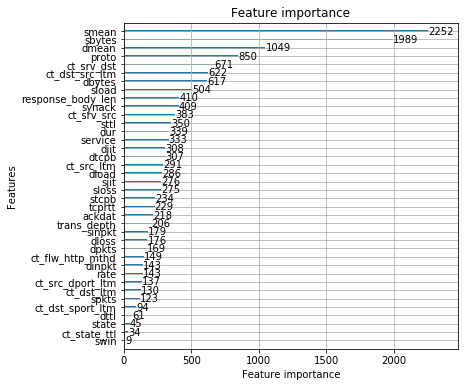

In [10]:
%matplotlib inline
gbm.plot_importance(clf,figsize=(6, 6))

In [8]:
imp=clf.feature_importance()
name=clf.feature_name()
feature_sorted=[]
for i in np.argsort(imp):
     feature_sorted.append(name[i])
feature_sorted.reverse()
f_set = feature_sorted

In [9]:
f_set

['smean',
 'sbytes',
 'dmean',
 'proto',
 'ct_srv_dst',
 'ct_dst_src_ltm',
 'dbytes',
 'sload',
 'response_body_len',
 'synack',
 'ct_srv_src',
 'sttl',
 'dur',
 'service',
 'djit',
 'dtcpb',
 'ct_src_ltm',
 'dload',
 'sjit',
 'sloss',
 'stcpb',
 'tcprtt',
 'ackdat',
 'trans_depth',
 'sinpkt',
 'dloss',
 'dpkts',
 'ct_flw_http_mthd',
 'dinpkt',
 'rate',
 'ct_src_dport_ltm',
 'ct_dst_ltm',
 'spkts',
 'ct_dst_sport_ltm',
 'dttl',
 'state',
 'ct_state_ttl',
 'swin',
 'ct_ftp_cmd',
 'dwin',
 'is_ftp_login',
 'is_sm_ips_ports']

In [11]:
acc_array = []
for a in range(len(f_set)):
    d_train=gbm.Dataset(x_tr_p2, label=y_tr_p2)
    params = {
        'task': 'train',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class':10,
        'learning_rate': 0.03,
        'verbose': 0,
        'tree_learner': 'voting',
    }
    #training the model
    clf_2 = gbm.train(params,d_train,50)
    y_pred = [np.argmax(line) for line in clf_2.predict(x_tr_p2)]
    acc_score = precision_score(y_pred,y_tr_p2,average=None).mean()
    acc_array.append(acc_score)
    print ("Top ",len(f_set)," feature accuracy result:",acc_score)
    x_tr_p2 = x_tr_p2.drop([f_set.pop()],axis=1)

Top  42  feature accuracy result: 0.609332870713
Top  41  feature accuracy result: 0.609332870713
Top  40  feature accuracy result: 0.609332870713
Top  39  feature accuracy result: 0.609332870713
Top  38  feature accuracy result: 0.609332870713
Top  37  feature accuracy result: 0.609332870713
Top  36  feature accuracy result: 0.60884486988
Top  35  feature accuracy result: 0.608590850285
Top  34  feature accuracy result: 0.609073764098
Top  33  feature accuracy result: 0.61044969843
Top  32  feature accuracy result: 0.609960369238
Top  31  feature accuracy result: 0.608289112693
Top  30  feature accuracy result: 0.607051409068
Top  29  feature accuracy result: 0.603632187016
Top  28  feature accuracy result: 0.604073145447
Top  27  feature accuracy result: 0.605031279863
Top  26  feature accuracy result: 0.604783272737
Top  25  feature accuracy result: 0.605030289262
Top  24  feature accuracy result: 0.602770361617
Top  23  feature accuracy result: 0.60697174027
Top  22  feature accura

In [12]:
print ("Max accuracy",np.max(acc_array),"with",42-np.argmax(acc_array),"features")

Max accuracy 0.61044969843 with 33 features


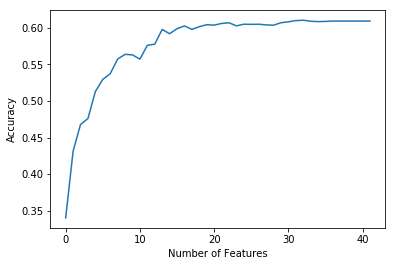

In [19]:
import matplotlib.pyplot as plt
acc_array.reverse()
plt.plot(acc_array)
plt.ylabel('Accuracy')
plt.xlabel('Number of Features')
plt.show()

In [20]:
imp=clf.feature_importance()
name=clf.feature_name()
feature_sorted=[]
for i in np.argsort(imp):
     feature_sorted.append(name[i])
feature_sorted.reverse()
f_set = feature_sorted

In [21]:
f_set[:22]

['smean',
 'sbytes',
 'dmean',
 'proto',
 'ct_srv_dst',
 'ct_dst_src_ltm',
 'dbytes',
 'sload',
 'response_body_len',
 'synack',
 'ct_srv_src',
 'sttl',
 'dur',
 'service',
 'djit',
 'dtcpb',
 'ct_src_ltm',
 'dload',
 'sjit',
 'sloss',
 'stcpb',
 'tcprtt']

In [5]:
x_tr_rnn = x_tr#[f_set[:23]]
x_ts_rnn = x_ts#[f_set[:23]]
y_tr_rnn = y_tr
u_list = [0.0,5.0,6.0,7.0]
t = TomekLinks(sampling_strategy=u_list,random_state=34)
x_tr_rnn, y_tr_rnn = t.fit_resample(x_tr_rnn,y_tr_rnn)

/home/alper/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/alper/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_tr_rnn = scaler.fit_transform(x_tr_rnn)
x_ts_rnn = scaler.transform(x_ts_rnn)

In [7]:
#PREPROCESSING FOR RECURRENT NETWORK
x = np.array(x_tr_rnn,dtype=np.float32)
y = np.array(y_tr_rnn,dtype=np.int32)
max_features = 10
y2 = np.zeros((y.shape[0], max_features),dtype=np.float32)
y2[np.arange(y.shape[0]), y] = 1.0
x = x[:,:,newaxis]

In [8]:
x_ts_rnn = np.array(x_ts_rnn,dtype=np.float32)
x_ts_rnn = x_ts_rnn[:,:,newaxis]

In [9]:
#GRUGBM_IDS
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from tensorflow.keras import regularizers
model = Sequential()
model.add(CuDNNGRU(120,input_shape=(None,1)))
model.add(Dense(10,activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],)
#TRAINING
start = time()
model.fit(x,y2,epochs=10)
print("Training %.2f seconds:" % ((time() - start)))

Epoch 1/10
161390/161390 [==============================] - 75s 466us/step - loss: 0.6686 - acc: 0.7531
Epoch 2/10
161390/161390 [==============================] - 74s 456us/step - loss: 0.5369 - acc: 0.7958
Epoch 3/10
161390/161390 [==============================] - 74s 459us/step - loss: 0.5092 - acc: 0.8037
Epoch 4/10
161390/161390 [==============================] - 74s 461us/step - loss: 0.4933 - acc: 0.8091
Epoch 5/10
161390/161390 [==============================] - 74s 456us/step - loss: 0.4772 - acc: 0.8136
Epoch 6/10
161390/161390 [==============================] - 74s 459us/step - loss: 0.4690 - acc: 0.8160
Epoch 7/10
161390/161390 [==============================] - 75s 464us/step - loss: 0.4637 - acc: 0.8178
Epoch 8/10
161390/161390 [==============================] - 74s 461us/step - loss: 0.4542 - acc: 0.8209
Epoch 9/10
161390/161390 [==============================] - 75s 465us/step - loss: 0.4492 - acc: 0.8226
Epoch 10/10
161390/161390 [==============================] - 75s

In [10]:
#TESTING DATA/ALL FEATURES WITH GRU
pred_new = model.predict(x_ts_rnn)
pred_new_clas = np.argmax(pred_new,axis=1)
acc = accuracy_score(y_ts,pred_new_clas)
conf=confusion_matrix(y_ts,pred_new_clas)
print (acc)
print (conf)
print(classification_report(y_ts,pred_new_clas))

0.747655832483
[[27138   423     1   209   951  7684     1   271   322     0]
 [    1     0     0     0   674     2     0     0     0     0]
 [    1     0     5     4   558     4     0     1    10     0]
 [   29     0     7   185  3684    98     1    24    61     0]
 [   92    12    20   175 10448   270     4    23    88     0]
 [  800     0     1     6  1649  3287     0   115   204     0]
 [    3     0     0    47   525   111 18151    17    17     0]
 [   17     0     3     6  1002   158     1  2106   203     0]
 [    4     0     1     0    68    49     0    20   236     0]
 [    1     0     0     1    39     3     0     0     0     0]]
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     37000
           1       0.00      0.00      0.00       677
           2       0.13      0.01      0.02       583
           3       0.29      0.05      0.08      4089
           4       0.53      0.94      0.68     11132
           5       0.28      

/home/alper/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#DECISIONTREE
from sklearn.tree import DecisionTreeClassifier
clf3 = DecisionTreeClassifier(random_state=42,class_weight='balanced')
x_tr_dt = x_tr[f_set[:23]]
x_ts_dt = x_ts[f_set[:23]]
clf3.fit(x_tr_dt,y_tr)
dt_pred = clf3.predict(x_ts_dt)
print (accuracy_score(y_ts,dt_pred))
print (confusion_matrix(y_ts,dt_pred))
print(classification_report(y_ts,dt_pred))

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
###
clf_knn = KNeighborsClassifier(n_neighbors=5)
x_tr_knn = x_tr[f_set[:23]]
x_ts_knn = x_ts[f_set[:23]]
scaler = StandardScaler()
x_tr_knn = scaler.fit_transform(x_tr_knn)
x_ts_knn = scaler.transform(x_ts_knn)
clf_knn.fit(x_tr_knn,y_tr)
knn_pred = clf_knn.predict(x_ts)
print (accuracy_score(y_ts,knn_pred))
print (confusion_matrix(y_ts,knn_pred))
print(classification_report(y_ts,knn_pred))###

In [ ]:
from sklearn.naive_bayes import BernoulliNB
clf_nb=BernoulliNB()
x_tr_nb = x_tr[f_set[:23]]
x_ts_nb = x_ts[f_set[:23]]
scaler = StandardScaler()
x_tr_nb = scaler.fit_transform(x_tr_nb)
x_ts_nb = scaler.transform(x_ts_nb)
clf_nb.fit(x_tr_nb,y_tr)
nb_pred = clf_nb.predict(x_ts_nb)
print (accuracy_score(y_ts,nb_pred))
print (confusion_matrix(y_ts,nb_pred))
print(classification_report(y_ts,nb_pred))###